# Sust Global Zonal Stats Endpoint Visualization Example

## Intro

This notebook provides a quick walk through on how the Sust Global zonal dataset for Canada.

We use zonal climate risk stats from Sust Global to show case an example baseline and 2050 hazard data.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, shape, Polygon
from IPython.display import display, HTML
import contextily as ctx
import matplotlib.pyplot as plt
import folium, matplotlib
import os

In [2]:
SUST_API_KEY = os.environ.get("SUST_API_KEY")
PROJECT = "ec-DEMO"

endpoints = {
    "tessellation": f"https://explorer.sustglobal-staging.io/api/zonalstats?country_code=USA&admin_level=2&tessellated&rows=100",
    "aggregation"  : f"https://explorer.sustglobal-staging.io/api/zonalstats?country_code=USA&admin_level=2&rows=100",
}

## Helper Functions

In [3]:
def fetch_paginated_data(endpoint):
    """
    Fetches all pages of data from a paginated API endpoint using Sust Global authentication headers.

    This function sends repeated GET requests to a paginated endpoint, incrementing the page number
    until a non-200 HTTP response is received. All JSON response data is collected and returned as a list.

    Args:
        endpoint (str): The base URL of the API endpoint (currently unused in implementation).

    Returns:
        list: A list containing the aggregated data from all successfully fetched pages.
    """
    
    # Set up authentication headers using API key and project identifier
    headers = {
        "X-SustGlobal-APIKey": SUST_API_KEY, 
        "X-SustGlobal-Project": PROJECT
    }
    
    page = 1     # Start with the first page
    buff = []    # Initialize a buffer to store all paginated results

    while True:
        # Construct the paginated URL using the current page number
        url = f'{endpoints[endpoint]}&page={page}'

        # Send GET request with headers
        response = requests.get(url, params={}, headers=headers)

        if response.status_code == 200:
            # If request is successful, append data to buffer
            buff += response.json()
            page += 1  # Move to the next page
        else:
            # If request fails (e.g., no more pages), return the accumulated data
            # print(f"Iterated {page} page(s)")
            return buff

def extract_summary_scores(gdf, scenario, hazard):
    """
    Extracts 30-year summary scores from a GeoDataFrame for a given scenario and hazard type.

    This function iterates through the provided GeoDataFrame `gdf`, accesses the nested 
    'scenario_analytics' field, and retrieves the `summary_score_30yr` value associated 
    with the specified climate scenario (e.g., 'ssp585') and hazard type (e.g., 'wildfire').

    Args:
        gdf (GeoDataFrame): The GeoPandas DataFrame containing a 'scenario_analytics' column.
        scenario (str): The climate scenario to filter by (e.g., 'ssp585').
        hazard (str): The hazard type to extract scores for (e.g., 'wildfire').

    Returns:
        list: A list of extracted summary scores for the specified scenario and hazard.
    """
    
    # Extract the summary scores for the given scenario and hazard
    scores = []
    
    for idx, row in gdf.iterrows():
        scenario_data = row['scenario_analytics']
        
        # Navigate through the nested structure, ex: ssp585 -> wildfire -> summary_score_30yr
        if scenario in scenario_data and hazard in scenario_data['ssp585']:
            score = scenario_data[scenario][hazard]['summary_score_30yr']
            scores.append(score)

    return scores

## Loading data

Loading data from the Sust Global API.

In [45]:
tessellation = fetch_paginated_data("tessellation")
aggregation = fetch_paginated_data("aggregation")

Convert the desired data to a geodataframe.

In [47]:
df = pd.DataFrame(aggregation)
gdf = gpd.GeoDataFrame(df.copy().drop("geometry", axis=1), geometry=df.geometry.apply(shape), crs="EPSG:4326")

display(gdf.shape)
display(gdf.head())

(3196, 14)

,id,country,admin_processing_level,lng,lat,polygon,admin0,admin1,admin2,admin3,admin4,labels,scenario_analytics,geometry
0,0,USA,2,-149.572986,62.315977,True,USA,Alaska,02170,,,"{'label:AFFGEOID': '0500000US02170', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"POLYGON ((-150.55172 61.29472, -150.53427 61.2..."
1,118,USA,2,-135.336255,59.562990,True,USA,Alaska,02230,,,"{'label:AFFGEOID': '0500000US02230', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"POLYGON ((-135.69827 59.73548, -135.71728 59.7..."
2,10,USA,2,-156.582888,20.863846,True,USA,Hawaii,15009,,,"{'label:AFFGEOID': '0500000US15009', 'label:CO...",{'ssp245': {'cyclone': {'business_interruption...,"MULTIPOLYGON (((-156.70729 20.91802, -156.7073..."
3,175,USA,2,-106.620188,52.798942,True,USA,Alaska,02016,,,"{'label:AFFGEOID': '0500000US02016', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"MULTIPOLYGON (((-176.67146 51.68116, -176.6736..."
4,126,USA,2,-164.027851,64.910956,True,USA,Alaska,02180,,,"{'label:AFFGEOID': '0500000US02180', 'label:AL...",{'ssp245': {'cyclone': {'business_interruption...,"MULTIPOLYGON (((-166.19764 64.48167, -166.1988..."


Extract data to visualize.

In [48]:
wildfire_scores = extract_summary_scores(gdf, "ssp585", "wildfire")
gdf_plotme = gdf.copy()
gdf_plotme['Wildfire_Score_SSP585'] = wildfire_scores

Plot!

(10.0, 80.0)

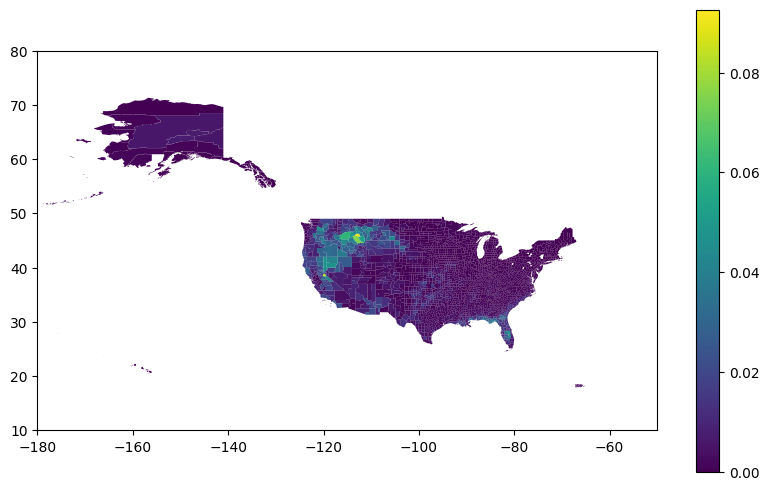

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
gdf_plotme.plot(column='Wildfire_Score_SSP585', ax=ax, legend=True)

ax.set_xlim(-180, -50) # Restrict longitude range (x-axis)
ax.set_ylim(10, 80)    # Restrict latitudinal range (y-axis)